# Analise de intervencoes do parlamento

## 1.Recolha e formatação de dados

Com base nos dados abertos disponibilizados no site da assembleia da republica, tive a ideia de investigar as varias [intervencoes](http://www.parlamento.pt/Cidadania/Paginas/DAIntervencoes.aspx) correspondentes a ultima legislatura. 

Começamos por importar alguns modulos importantes: 

In [1]:
import json
import pandas as pd
from pprint import pprint
from collections import Counter
from __future__ import division
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Após downloadar os dados no formato json, transferimos para um dictionario chamado `interventions`.

In [2]:
with open('data/IntervencoesXIII.json') as data_file:    
    data = json.load(data_file)
    
interventions = data['ArrayOfPt_gov_ar_objectos_intervencoes_DadosPesquisaIntervencoesOut']['pt_gov_ar_objectos_intervencoes_DadosPesquisaIntervencoesOut']
print 'O dictionario tem {} intervencoes.'.format(len(interventions))

O dictionario tem 11072 intervencoes.


Vamos fazer um print da primeira intervenção:

In [3]:
pprint(interventions[0])

{u'actividadeId': u'102944',
 u'actividadesRelacionadas': {u'id': u'102944', u'tipo': u'Disc. Iniciativas'},
 u'dataReuniaoPlenaria': u'2016-07-20',
 u'deputados': {u'GP': u'PS',
                u'idCadastro': u'1600',
                u'nome': u'JAMILA MADEIRA'},
 u'faseSessao': u'POD',
 u'idDebate': u'30572',
 u'iniciativas': {u'pt_gov_ar_objectos_intervencoes_IniciativasOut': {u'fase': u'Vota\xe7\xe3o Delibera\xe7\xe3o',
                                                                      u'id': u'40581',
                                                                      u'tipo': u'Projeto de Resolu\xe7\xe3o'}},
 u'legislatura': u'XIII',
 u'publicacao': {u'pt_gov_ar_objectos_PublicacoesOut': {u'URLDiario': u'http://debates.parlamento.pt/catalogo/r3/dar/01/13/01/089/2016-07-21/115?pgs=115&org=PLC',
                                                        u'idAct': None,
                                                        u'idDeb': None,
                                         

Vamos obrigar as nossa intervencoes a ter alguns campos essenciais.

In [4]:
must_have_fields = ['deputados', 'dataReuniaoPlenaria', 'sumario']

E criamos uma list a partir da qual vamos criar uma Pandas dataframe:

In [5]:
pandas_data = [['id_debate', 'date', 'phase', 'speaker', 'political_party', 'summary_text', 'intervention_type']]

In [6]:
# initialize counters
total = 0
retrieved = 0

# loop over list
for intervention in interventions:
    total += 1
    if all(x in intervention.keys() for x in must_have_fields):
        # define fields
        debate_id = intervention['idDebate']
        date = intervention['dataReuniaoPlenaria']
        phase = intervention['faseSessao']
        speaker = intervention['deputados']['nome']
        political_party = intervention['deputados']['GP']
        summary_text = intervention['sumario']
        intervention_type_text = intervention['tipoIntervencao']
        
        # add to pandas list
        pandas_data += [[debate_id, date, phase, speaker, political_party, summary_text, intervention_type_text]] 
        retrieved += 1

Perdemos? 

In [7]:
print 'Intervencoes parsadas: ', total
print 'Intervencoes que foram aceites: ', retrieved
print 'Perdemos {}%.'.format(round(retrieved/total,2))

Intervencoes parsadas:  11072
Intervencoes que foram aceites:  10593
Perdemos 0.96%.


Criamos dataframe: 

In [8]:
assembleia = pd.DataFrame(pandas_data[1:], columns=pandas_data[0])
assembleia = assembleia.drop_duplicates()

## 2.Analise preliminar

Imprimimos a cabeça:

In [9]:
assembleia.head()

,id_debate,date,phase,speaker,political_party,summary_text,intervention_type
0,30572,2016-07-20,POD,JAMILA MADEIRA,PS,Recomenda ao Governo a elaboração de levantame...,Declaração de voto
1,30571,2016-07-20,POD,JOÃO OLIVEIRA,PCP,Regula o acesso à gestação de substituição nos...,Declaração de voto
2,30592,2016-07-20,POD,LUÍS MONTENEGRO,PSD,Cria um regime de reembolso de impostos sobre ...,Declaração de voto
3,30591,2016-07-20,POD,ANA MESQUITA,PCP,"Terceira alteração à Lei n.º 54/2005, de 15 de...",Declaração de voto
4,30590,2016-07-20,POD,ANA MESQUITA,PCP,"Altera a Lei n.º 54/2005, de 15 de novembro, q...",Declaração de voto


In [10]:
assembleia.shape
print 'Temos {} colunas e {} linhas.'.format(assembleia.shape[1], assembleia.shape[0])

Temos 7 colunas e 10449 linhas.


Tipos de dados? 

In [11]:
assembleia.dtypes

id_debate            object
date                 object
phase                object
speaker              object
political_party      object
summary_text         object
intervention_type    object
dtype: object

Quais os diferentes partidos e tipos de intervenções? 

In [12]:
party_names = list(assembleia.political_party.unique())

print party_names

party_colors_rgb = [(255, 86, 231), (255, 0, 1), (255, 142, 2), (0, 136, 216), (1, 117, 0), (124, 10, 11), (0, 117, 117)]



[u'PS', u'PCP', u'PSD', u'CDS-PP', u'PEV', u'BE', u'PAN']


In [13]:
for tipo_de_intervencao in list(assembleia.intervention_type.unique()):
    print tipo_de_intervencao

Declaração de voto
Declaração politica
Defesa da honra
Explicações
Interpelação à mesa
Intervenção
Leitura
Pedido de esclarecimento
Pergunta
Réplica
Defesa da consideração
Recurso da decisão da mesa


In [14]:
assembleia.political_party.value_counts(normalize=True)

PS        0.250263
PSD       0.238205
PCP       0.151881
CDS-PP    0.146138
BE        0.136951
PEV       0.051297
PAN       0.025266
Name: political_party, dtype: float64

In [15]:
assembleia.intervention_type.value_counts(normalize=True)

Intervenção                   0.493444
Declaração de voto            0.208058
Pedido de esclarecimento      0.162886
Leitura                       0.047373
Pergunta                      0.039908
Interpelação à mesa           0.027754
Declaração politica           0.014547
Explicações                   0.002488
Defesa da honra               0.001818
Réplica                       0.001531
Defesa da consideração        0.000096
Recurso da decisão da mesa    0.000096
Name: intervention_type, dtype: float64

In [16]:
assembleia.speaker.value_counts(normalize=False)

HELOÍSA APOLÓNIA             282
ANDRÉ SILVA                  264
JOSÉ LUÍS FERREIRA           254
PEDRO FILIPE SOARES          178
ANTÓNIO FILIPE               171
JOÃO OLIVEIRA                160
NUNO MAGALHÃES               150
CARLA CRUZ                   145
ANTÓNIO CARLOS MONTEIRO      139
PAULA SANTOS                 139
BRUNO DIAS                   133
RITA RATO                    132
DUARTE PACHECO               132
MOISÉS FERREIRA              131
IDÁLIA SALVADOR SERRÃO       130
EDUARDO FERRO RODRIGUES      129
JOÃO RAMOS                   129
CECÍLIA MEIRELES             112
ANA MESQUITA                 108
JOANA MORTÁGUA               107
MARIANA MORTÁGUA             106
CARLOS CÉSAR                 105
HELDER AMARAL                104
ANA RITA BESSA               103
PEDRO MOTA SOARES            100
VÂNIA DIAS DA SILVA           99
JOSÉ MOURA SOEIRO             98
JOÃO PINHO DE ALMEIDA         94
DIANA FERREIRA                92
SUSANA AMADOR                 88
          

In [17]:
assembleia[assembleia.political_party == 'PCP'].intervention_type.value_counts(normalize=True)

Intervenção                   0.545684
Pedido de esclarecimento      0.194077
Declaração de voto            0.174543
Pergunta                      0.036547
Interpelação à mesa           0.022054
Declaração politica           0.017643
Leitura                       0.003781
Explicações                   0.001890
Réplica                       0.001890
Defesa da consideração        0.000630
Defesa da honra               0.000630
Recurso da decisão da mesa    0.000630
Name: intervention_type, dtype: float64

In [18]:
assembleia[assembleia.political_party == 'PSD'].intervention_type.value_counts(normalize=True)

Intervenção                 0.416633
Declaração de voto          0.290880
Pedido de esclarecimento    0.153475
Interpelação à mesa         0.047810
Leitura                     0.046203
Pergunta                    0.027320
Declaração politica         0.010848
Réplica                     0.002812
Defesa da honra             0.002411
Explicações                 0.001607
Name: intervention_type, dtype: float64

In [19]:
assembleia[assembleia.political_party == 'PS'].intervention_type.value_counts(normalize=True)

Intervenção                 0.395793
Declaração de voto          0.306310
Pedido de esclarecimento    0.128107
Leitura                     0.097897
Pergunta                    0.032887
Interpelação à mesa         0.021415
Declaração politica         0.011472
Explicações                 0.004589
Defesa da honra             0.001530
Name: intervention_type, dtype: float64

In [20]:
assembleia[assembleia.political_party == 'BE'].intervention_type.value_counts(normalize=True)

Intervenção                 0.602376
Pedido de esclarecimento    0.220126
Declaração de voto          0.066387
Pergunta                    0.041230
Leitura                     0.030748
Declaração politica         0.016771
Interpelação à mesa         0.016771
Explicações                 0.002795
Réplica                     0.002096
Defesa da honra             0.000699
Name: intervention_type, dtype: float64

In [21]:
assembleia.loc[assembleia.speaker == 'RITA RATO']

,id_debate,date,phase,speaker,political_party,summary_text,intervention_type
94,30475,2016-06-02,POD,RITA RATO,PCP,Reposição das 35 horas de trabalho semanal na ...,Declaração de voto
98,30476,2016-06-02,POD,RITA RATO,PCP,35 horas para maior criação de emprego e repos...,Declaração de voto
102,30477,2016-06-02,POD,RITA RATO,PCP,Estabelece as 35 horas como período normal de ...,Declaração de voto
185,30474,2016-06-02,POD,RITA RATO,PCP,Repõe as 35 horas por semana como período norm...,Declaração de voto
188,30637,2016-05-20,POD,RITA RATO,PCP,Reformulação da atribuição do subsídio de educ...,Declaração de voto
191,30636,2016-05-20,POD,RITA RATO,PCP,Reposição da legalidade na atribuição do subsí...,Declaração de voto
199,30635,2016-05-20,POD,RITA RATO,PCP,Reposição da legalidade na atribuição do subsí...,Declaração de voto
343,30532,2016-05-04,POD,RITA RATO,PCP,"8.ª Alteração à Lei nº 53-B/2006, de 29 de dez...",Declaração de voto
345,30535,2016-05-04,POD,RITA RATO,PCP,Procede à oitava alteração à Lei n.º 53-B/2006...,Declaração de voto
626,30105,2015-12-18,POD,RITA RATO,PCP,Extinção das reduções remuneratórias na admini...,Declaração de voto


In [22]:
assembleia.groupby('intervention_type').political_party.value_counts(normalize=True)


intervention_type           political_party
Declaração de voto          PS                 0.368445
                            PSD                0.333027
                            PCP                0.127415
                            CDS-PP             0.112695
                            BE                 0.043698
                            PAN                0.008280
                            PEV                0.006440
Declaração politica         PS                 0.197368
                            CDS-PP             0.184211
                            PCP                0.184211
                            PSD                0.177632
                            BE                 0.157895
                            PEV                0.098684
Defesa da consideração      PCP                1.000000
Defesa da honra             CDS-PP             0.368421
                            PSD                0.315789
                            PS                 0.210526
    

In [23]:
assembleia.date.str.slice(0, 4).value_counts()

2017    3952
2016    3793
2018    2090
2015     614
Name: date, dtype: int64

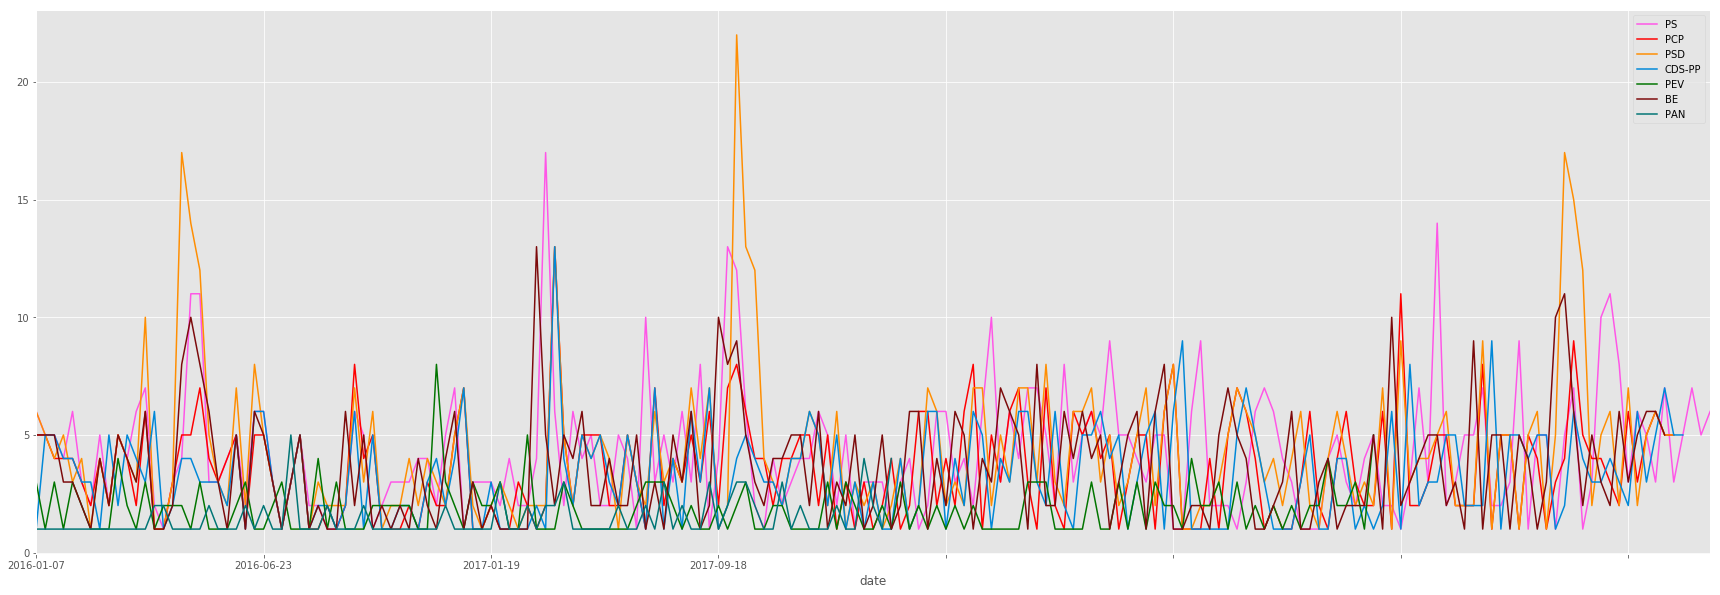

In [38]:
plt.figure(figsize=(30, 10))

for index, partido in enumerate(party_names):
    assembleia[(assembleia.intervention_type==u'Intervenção') 
               & (assembleia.political_party==partido)
               & (assembleia['date'] > '2016-01-01')
               & (assembleia['date'] < '2017-12-30') ].groupby(assembleia.date).intervention_type.count().plot(label=partido, color=tuple(e/255 for e in party_colors_rgb[index]))
    
plt.legend()

#a[(assembleia.political_party=='PSD') & (assembleia.intervention_type==u'Intervenção')].groupby(assembleia.date).intervention_type.count().plot(label='PSD')
#plt.legend()
#assembleia[(assembleia.intervention_type==u'Intervenção')].groupby(assembleia.date).intervention_type.count().plot()
#plt.legend()

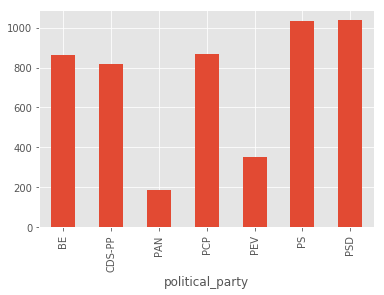

In [40]:
assembleia[(assembleia.intervention_type==u'Intervenção')].groupby('political_party').intervention_type.count().plot(kind='bar')